In [1]:
from pymatgen.ext.matproj import MPRester, Composition
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import math
import pprint
%matplotlib inline  


In [2]:
# get data from materials project
with MPRester("8kovBjpngTHHQ1juZK") as m:
    elasticity_data = m.query({"elasticity": {"$exists": True}}, properties=["task_id", 
                                                                          "pretty_formula", 
                                                                          "spacegroup", 
                                                                          "band_gap", 
                                                                          "elasticity", 
                                                                          "density"])
    with open('elasticity-data.json', 'w') as f:
        json.dump(elasticity_data, f)

  0%|          | 0/13172 [00:00<?, ?it/s]

In [3]:
# load data from json file 
# with open('elasticity-data.json', 'r') as f:
#     elastic_data = json.load(f)
pprint.pprint(elasticity_data[4])

{'band_gap': 0.0,
 'density': 4.0085093080331395,
 'elasticity': {'G_Reuss': 135.0,
                'G_VRH': 176.0,
                'G_Voigt': 216.0,
                'G_Voigt_Reuss_Hill': 176.0,
                'K_Reuss': 241.0,
                'K_VRH': 241.0,
                'K_Voigt': 241.0,
                'K_Voigt_Reuss_Hill': 241.0,
                'compliance_tensor': [[5.0, -1.8, -1.8, 0.0, 0.0, -0.0],
                                      [-1.8, 5.0, -1.8, -0.0, 0.0, 0.0],
                                      [-1.8, -1.8, 5.0, 0.0, -0.0, 0.0],
                                      [0.0, -0.0, 0.0, 3.2, -0.0, -0.0],
                                      [0.0, 0.0, -0.0, -0.0, 3.2, -0.0],
                                      [-0.0, 0.0, 0.0, -0.0, -0.0, 3.2]],
                'elastic_anisotropy': 2.99,
                'elastic_tensor': [[338.0, 192.0, 192.0, 0.0, 0.0, 0.0],
                                   [192.0, 338.0, 192.0, 0.0, 0.0, 0.0],
                               

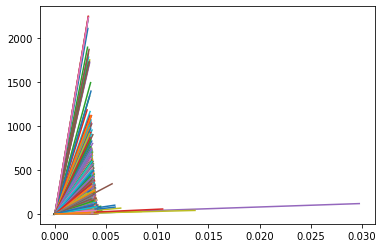

In [4]:
def stress_to_strain(stress):
    strain = []
    strain.append((1/young_modulus)*(stress[0] - poisson_ratio*(stress[1] + stress[2])))
    strain.append((1/young_modulus)*(stress[1] - poisson_ratio*(stress[0] + stress[2])))
    strain.append((1/young_modulus)*(stress[2] - poisson_ratio*(stress[0] + stress[1])))
    strain.append((1/shear_modulus)*stress[3])
    strain.append((1/shear_modulus)*stress[4])
    strain.append((1/shear_modulus)*stress[5])
    return strain

def plot_stress_strain_curve(young_modulus):
    stress_list = np.linspace(0, .002*young_modulus, 100)
    strain_list = []
    for stress_norm in stress_list:
        s = stress_norm/math.sqrt(6)
        stress = [s,s,s,s,s,s]
        strain = stress_to_strain(stress)
        strain_list.append(np.linalg.norm(strain))
    return plt.plot(strain_list, 1000*stress_list)

def yield_strength(young_modulus):
    stress = .002*young_modulus
    s = stress/math.sqrt(6)
    strain = stress_to_strain([s,s,s,s,s,s])
    strain = np.linalg.norm(np.array(strain))
    return [round(stress*1000), round(strain, 4)]

elasticity_dict = {'formula': [], 
                'space group': [], 
                'yield stress (MPa)': [], 
                'density (g/cm^3)': [], 
                'band gap (eV)': []}

for i in range(len(elasticity_data)):
    if elasticity_data[i]['band_gap'] == 0:
        continue
    bulk_modulus = elasticity_data[i]['elasticity']['K_Voigt_Reuss_Hill']
    if elasticity_data[i]['elasticity']['G_Voigt_Reuss_Hill'] > 0:
        shear_modulus = elasticity_data[i]['elasticity']['G_Voigt_Reuss_Hill']
    elif elasticity_data[i]['elasticity']['G_Voigt'] > 0:
        shear_modulus = elasticity_data[i]['elasticity']['G_Voigt']
    elif elasticity_data[i]['elasticity']['G_Reuss'] > 0:
        shear_modulus = elasticity_data[i]['elasticity']['G_Reuss']
    poisson_ratio = elasticity_data[i]['elasticity']['poisson_ratio']
    if 3*bulk_modulus + shear_modulus == 0:
        continue
    young_modulus = 9*bulk_modulus*shear_modulus/(3*bulk_modulus + shear_modulus)
    if young_modulus == 0 or shear_modulus == 0:
        continue
    
    elasticity_dict['formula'].append(str(elasticity_data[i]['pretty_formula']) + '-' + str(elasticity_data[i]['task_id'])) 
    elasticity_dict['space group'].append(str(elasticity_data[i]['spacegroup']['symbol']))
    elasticity_dict['yield stress (MPa)'].append(yield_strength(young_modulus)[0])
    elasticity_dict['density (g/cm^3)'].append(str(round(elasticity_data[i]['density'], 4)))
    elasticity_dict['band gap (eV)'].append(str(round(elasticity_data[i]['band_gap'], 4)))
    
    plot_stress_strain_curve(young_modulus)

In [5]:
df = pd.DataFrame(data = elasticity_dict).sort_values(by = ['yield stress (MPa)'], ascending = False)
df.to_csv('elasticity-data.csv', index = False)